In [13]:
from ecl.summary import EclSum
from ecl.grid import EclGrid
from ecl.eclfile import EclInitFile, EclRestartFile

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [14]:
pflotran_working_root = '/scratch/SCS/gpb/SCREEN/cases/cosmo_aq/model'

sim_case = 'TEMP-0'

sim_path = pflotran_working_root+'/'+sim_case


grid = EclGrid(sim_path + ".EGRID")
init = EclInitFile(grid ,sim_path + ".INIT")
rst = EclRestartFile(grid ,sim_path + ".UNRST")
summary = EclSum(sim_path).pandas_frame()

In [15]:
def check_LGR(a_idx):
        """Function that maps LGR cells"""
        LGR_cell = False
        try:
                grid.get_cell_lgr(active_index=a_idx)
                LGR_cell = True
        except:
                pass

        return LGR_cell


def molefrac_to_massfrac(amfg, amfw):
        """Function to convert mole fractions to mass fractions"""

        MW_WAT    = 18.01528E-3  #Water Molecular Weight (kg/mol)
        MW_CO2    = 44.01E-3  #CO2 Molecular Weight (kg/mol)
        
        n_tot = 100 # kgmol total

        n_CO2 = amfg*n_tot
        n_WAT = amfw*n_tot

        m_CO2 = n_CO2*MW_CO2
        m_WAT = n_WAT*MW_WAT

        m_TOT = m_CO2 + m_WAT

        X_CO2 = m_CO2 / m_TOT
        X_WAT = m_WAT / m_TOT

        return X_CO2, X_WAT


In [16]:

#Process init file
lgr_name = grid.get_lgr(0).get_name()
lgr_grid = grid.get_lgr(lgr_name)
df_init_lgr = lgr_grid.export_index()
df_init_crs = grid.export_index()

df_init_crs['LGR'] = df_init_crs['active'].map(check_LGR)


df_rst_lgr = df_init_lgr.copy()
df_rst_crs = df_init_crs.copy()


# Static properties Dataframe
for key in init.keys():
        try:
                df_init_lgr[key] = init[key][1].numpy_view()
                df_init_crs[key] = init[key][0].numpy_view()
        except:
                continue


#Retrieve time steps from restart file
tsteps = rst.timeList() #No. of timesteps and time value
tstep_index = np.array(rst.timeList())[:,0]
n_tsteps = len(tsteps)


t_idx_lgr = np.repeat(tstep_index,df_init_lgr.shape[0]) #Repeat/tile time step index the number of LGR cells
t_idx_crs = np.repeat(tstep_index,df_init_crs.shape[0]) #Repeat/tile time step index the number of COARSE cells


df_rst_lgr = pd.concat([df_rst_lgr]*n_tsteps) #Repeat indexes the number of time steps
df_rst_crs = pd.concat([df_rst_crs]*n_tsteps) #Repeat indexes the number of time steps


df_rst_crs['tstep'] = t_idx_crs
df_rst_lgr['tstep'] = t_idx_lgr

# df_rst_crs = df_rst_crs.set_index('tstep')
# df_rst_lgr = df_rst_lgr.set_index('tstep')

for key in rst.keys():
        
        #Retrieve first record of LGR and COARSE restart properties to verify dtype and dimensions
        lgr_0 = rst[key][1]
        crs_0 = rst[key][0]

        #Check if array contents are numeric
        crs_isNum = lgr_0.isNumeric()
        lgr_isNum = crs_0.isNumeric()

        isNum = crs_isNum and lgr_isNum

        #Check if array size matches number of cells
        chk_lgr_size = len(lgr_0) == lgr_grid.getGlobalSize()
        chk_crs_size = len(crs_0) == grid.getGlobalSize()

        
        chk_size = chk_lgr_size and chk_crs_size

        if isNum and chk_size:
                
                key_list = list(map(lambda obj: obj.numpy_view(), rst[key]))
                crs_key = np.array(key_list[0::2])
                lgr_key = np.array(key_list[1::2])

                df_rst_crs[key] = crs_key.flatten()
                df_rst_lgr[key] = lgr_key.flatten()





#Calculate free CO2 in KG Sat x Pore Vol x Density [M3/M3 x M3 x KG/M3]
#kg of free CO2
df_rst_crs['CO2_G'] = df_rst_crs['DGAS']*df_rst_crs['SGAS'] * np.hstack([df_init_crs['PORV']]*n_tsteps)
df_rst_lgr['CO2_G'] = df_rst_lgr['DGAS']*df_rst_lgr['SGAS'] * np.hstack([df_init_lgr['PORV']]*n_tsteps)


#kg of CO2 dissolved in water
crs_mass_fractions = np.array(list(map(molefrac_to_massfrac, df_rst_crs["AMFG"], df_rst_crs["AMFW"])))
lgr_mass_fractions = np.array(list(map(molefrac_to_massfrac, df_rst_lgr["AMFG"], df_rst_lgr["AMFW"])))

df_rst_crs['X_CO2'] = crs_mass_fractions[:, 0]
df_rst_crs['X_H2O'] = crs_mass_fractions[:, 1]

df_rst_lgr['X_CO2'] = lgr_mass_fractions[:, 0]
df_rst_lgr['X_H2O'] = lgr_mass_fractions[:, 1]

df_rst_crs['CO2_AQ'] = df_rst_crs['DWAT'] * df_rst_crs['SWAT'] * np.hstack([df_init_crs['PORV']]*n_tsteps) * df_rst_crs['X_CO2']
df_rst_lgr['CO2_AQ'] = df_rst_lgr['DWAT'] * df_rst_lgr['SWAT'] * np.hstack([df_init_lgr['PORV']]*n_tsteps) * df_rst_lgr['X_CO2']

#Map regions into RST tables
df_rst_crs['FIPLEG'] = np.hstack([df_init_crs['FIPLEG']]*n_tsteps)
df_rst_lgr['FIPLEG'] = np.hstack([df_init_lgr['FIPLEG']]*n_tsteps)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


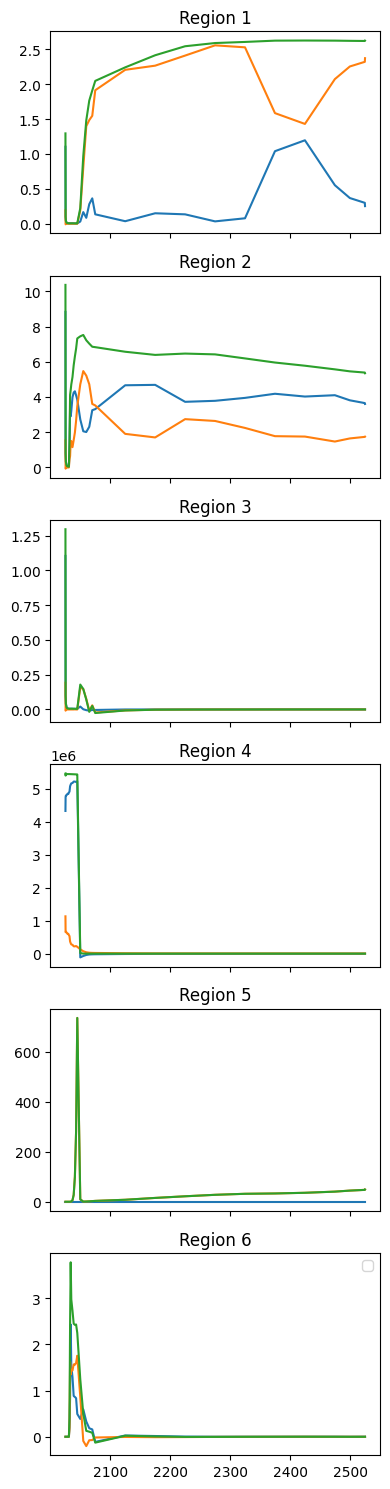

In [65]:
time = np.array(tsteps)[:,1]

fig, ax = plt.subplots(6,1, figsize=(4, 15), sharex=True)

for i in range(6):
        region = i+1

        if region in df_rst_crs['FIPLEG'].values:
                total_crs = df_rst_crs.query('FIPLEG==@region').groupby('tstep').sum()
        else:
                total_crs = 0

        if region in df_rst_lgr['FIPLEG'].values:
                total_lgr = df_rst_lgr.query('FIPLEG==@region').groupby('tstep').sum()
        else:
                total_lgr = 0

        total = total_crs + total_lgr

        total['time'] = time

        ax[i].set_title(f'Region {region}')
        # ax[i].plot(time, total['CO2_AQ'], label = '$CO_{2(aq)}$')
        # ax[i].plot(time, total['CO2_G'], ls ='--', )
        # ax[i].plot(time, total['CO2_G']+total['CO2_AQ'], ls ='--', )
        

        a = (total['CO2_G'].diff() / total['time'].diff().dt.total_seconds())*3600*24
        b = (total['CO2_AQ'].diff() / total['time'].diff().dt.total_seconds())*3600*24

        # fig, ax = plt.subplots()

        ax[i].plot(total['time'], a)
        ax[i].plot(total['time'], b)
        ax[i].plot(total['time'], a+b)

ax[i].legend()

# total_crs
fig.tight_layout()

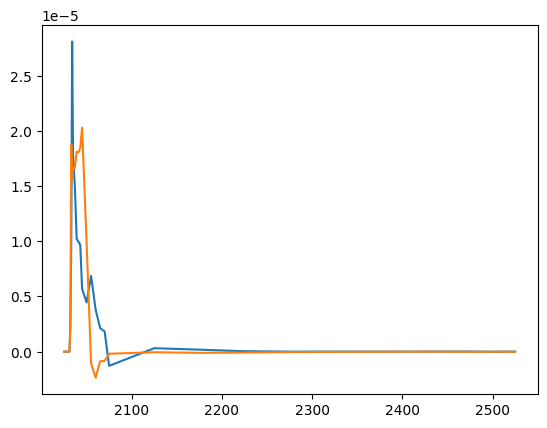

In [57]:
a = total['CO2_G'].diff() / total['time'].diff().dt.total_seconds()
b = total['CO2_AQ'].diff() / total['time'].diff().dt.total_seconds()

fig, ax = plt.subplots()

ax.plot(total['time'], a)
ax.plot(total['time'], b)

In [53]:
a
total

,i,j,k,active,PRESSURE,SWAT,DWAT,VWAT,SGAS,DGAS,...,AMFG,AMFW,YMFG,YMFW,CO2_G,X_CO2,X_H2O,CO2_AQ,FIPLEG,time
tstep,,,,,,,,,,,,,,,,,,,,,
0,94542,94542,525904,256712002,9.907426e+05,9004.000000,8924689.0,6957.365723,0.000000,3413076.50,...,0.000000e+00,9004.000000,8990.932617,13.067004,0.000000,0.000000e+00,9004.000000,0.000000e+00,54024,2025-01-01 00:00:00
1,94542,94542,525904,256712002,9.925065e+05,9004.000000,8924767.0,6957.365723,0.000000,3416630.75,...,2.571867e-30,9004.000000,8990.959961,13.039751,0.000000,6.282882e-30,9004.000000,8.283664e-29,54024,2025-04-02 00:00:00
2,94542,94542,525904,256712002,9.930705e+05,9004.000000,8924792.0,6957.365723,0.000000,3417761.75,...,3.953144e-25,9004.000000,8990.968750,13.031095,0.000000,9.657239e-25,9004.000000,1.273321e-23,54024,2025-07-03 00:00:00
3,94542,94542,525904,256712002,9.941517e+05,9004.000000,8924840.0,6957.365723,0.000000,3419920.00,...,1.143601e-19,9004.000000,8990.985352,13.014562,0.000000,2.793734e-19,9004.000000,3.684079e-18,54024,2026-01-01 00:00:00
4,94542,94542,525904,256712002,9.962892e+05,9004.000000,8924934.0,6957.365723,0.000000,3424155.00,...,3.264075e-14,9004.000000,8991.017578,12.982118,0.000000,7.973894e-14,9004.000000,1.051800e-12,54024,2027-01-01 00:00:00
5,94542,94542,525904,256712002,9.984063e+05,9004.000000,8925028.0,6957.365723,0.000000,3428309.25,...,4.036826e-11,9004.000000,8991.049805,12.950299,0.000000,9.861669e-11,9004.000000,1.301210e-09,54024,2028-01-01 00:00:00
6,94542,94542,525904,256712002,1.000536e+06,9004.000000,8925122.0,6957.365723,0.000000,3432446.50,...,8.365849e-09,9004.000000,8991.081055,12.918611,0.000000,2.043715e-08,9004.000000,2.698971e-07,54024,2028-12-31 00:00:00
7,94542,94542,525904,256712002,1.002655e+06,9004.000000,8925216.0,6957.365723,0.000000,3436521.50,...,3.585479e-06,9004.000000,8991.112305,12.887389,0.000000,8.759060e-06,9003.999991,1.146648e-04,54024,2029-12-31 00:00:00
8,94542,94542,525904,256712002,1.004804e+06,9004.000000,8925313.0,6957.365723,0.000000,3440613.75,...,7.470591e-03,9003.992188,8991.143555,12.856050,0.000000,1.824953e-02,9003.981750,9.485772e-02,54024,2030-12-31 00:00:00


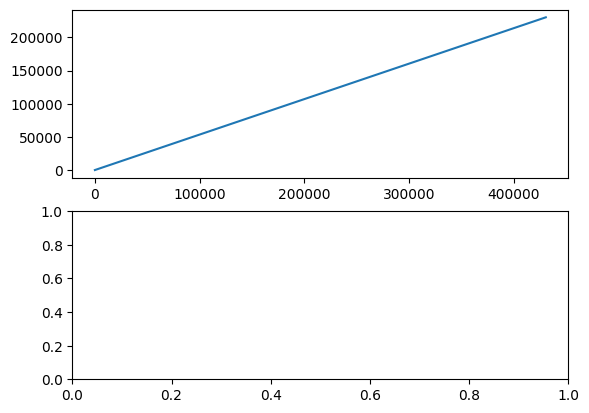

In [90]:
fig, (ax, ax2) = plt.subplots(2,1)

total = summary[['RGFT_LEG:1-2','RGFT_LEG:1-3','RGFT_LEG:1-4','RGFT_LEG:1-5','RGFT_LEG:1-6']].sum(axis=1)

ax.plot(summary[f'RGMIPLEG:{1}'], -total)
# ax2.plot(summary.index, )
# ax.plot(summary.index, -summary['RWFR_LEG:1-6'])

# ax2.plot(summary.index, -summary['RGFR_LEG:3-6'])
# ax2.plot(summary.index, -summary['RWFR_LEG:3-6'])


# ax.plot(summary.index, -summary['RGFR_LEG:3-6'])
# ax.plot(summary.index, summary['FGIR'])

In [135]:

from matplotlib import rcParams
from matplotlib import font_manager
%matplotlib inline

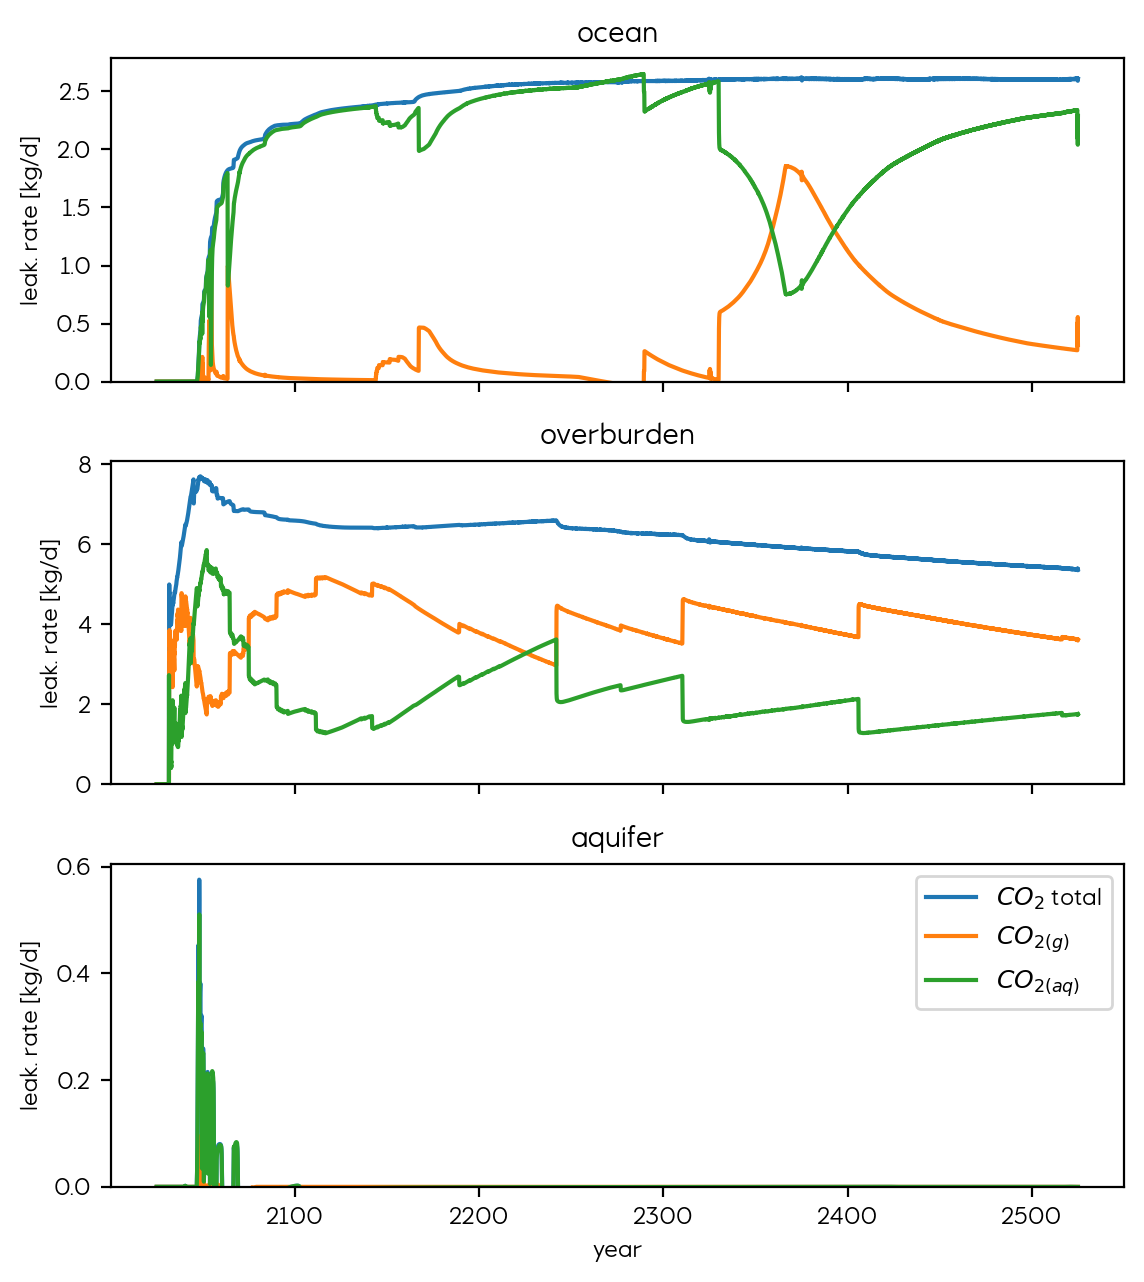

In [136]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

time = np.array(tsteps)[:,1]

fig, ax = plt.subplots(3,1, figsize=(5.79, 6.48), sharex=True)

summary['time'] = summary.index

summary['time'].diff()
summary['dt'] = summary['time'].diff()
summary['dt_s'] =  summary['dt'].dt.total_seconds()

summary_q = summary.query('dt_s>1*24*3600')

reg_name = {1:'ocean',
            2:'overburden',
            3:'aquifer'}

for i in range(3):
        region = i+1
        ax[i].set_title(reg_name[region])

        summary[f'RGRIPLEG:{region}'] = summary[f'RGMIPLEG:{region}'].diff() / summary['dt'].dt.total_seconds()*3600*24
        summary[f'RGRGPLEG:{region}'] = summary[f'RGMGPLEG:{region}'].diff() / summary['dt'].dt.total_seconds()*3600*24
        summary[f'RGRDSLEG:{region}'] = summary[f'RGMDSLEG:{region}'].diff() / summary['dt'].dt.total_seconds()*3600*24

        ax[i].plot(summary_q.index, summary_q[f'RGRIPLEG:{region}'], label='$CO_2$ total')
        # ax[i].plot(summary['dt'].dt.total_seconds()*3600*24, summary[f'RGRGPLEG:{region}'], label='CO2 mas in place')
        ax[i].plot(summary_q.index, summary_q[f'RGRGPLEG:{region}'], label='$CO_{2(g)}$')
        ax[i].plot(summary_q.index, summary_q[f'RGRDSLEG:{region}'], label='$CO_{2(aq)}$')
        # ax[i].plot(summary.index, summary[f'RGMMOLEG:{region}'], label='mobile',ls='--')
        # ax[i].plot(summary.index, summary[f'RGMTRLEG:{region}'], label='stranded',ls='--')
        # ax[i].plot(summary.index, summary[f'RGMUSLEG:{region}'], label='unstranded',ls='--')
        # ax[i].plot(summary.index, summary[f'RGMIPLEG:{region}'], label='GIP')
        ax[i].set_ylim(bottom=0)
        ax[i].set_ylabel('leak. rate [kg/d]')



ax[i].legend()
ax[i].set_xlabel('year')


# total_crs
fig.tight_layout()

In [119]:
summary['dt'].dt.total_seconds().min()

0.0

In [102]:
summary[f'RGMIPLEG:{region}'].diff()

2025-01-01 00:00:00         NaN
2025-01-02 00:00:00     0.00000
2025-01-03 00:00:00     0.00000
2025-01-04 00:00:00     0.00000
2025-01-05 00:00:00     0.00000
                         ...   
2524-12-03 12:00:00     3.96875
2524-12-06 13:30:00     8.00000
2524-12-12 16:30:00    15.96875
2524-12-24 22:07:30    31.90625
2525-01-01 00:00:00    18.46875
Name: RGMIPLEG:1, Length: 13053, dtype: float64

In [103]:
summary['dt']

2025-01-01 00:00:00                NaT
2025-01-02 00:00:00    1 days 00:00:00
2025-01-03 00:00:00    1 days 00:00:00
2025-01-04 00:00:00    1 days 00:00:00
2025-01-05 00:00:00    1 days 00:00:00
                            ...       
2524-12-03 12:00:00    1 days 12:45:00
2524-12-06 13:30:00    3 days 01:30:00
2524-12-12 16:30:00    6 days 03:00:00
2524-12-24 22:07:30   12 days 05:37:30
2525-01-01 00:00:00    7 days 01:52:30
Name: dt, Length: 13053, dtype: timedelta64[ns]

In [80]:
summary.columns[summary.columns.str.startswith('RGFR')]

Index(['RGFR_LEG:1-2', 'RGFR_LEG:1-3', 'RGFR_LEG:1-4', 'RGFR_LEG:1-5',
       'RGFR_LEG:1-6', 'RGFR_LEG:2-3', 'RGFR_LEG:2-4', 'RGFR_LEG:2-5',
       'RGFR_LEG:2-6', 'RGFR_LEG:3-4', 'RGFR_LEG:3-5', 'RGFR_LEG:3-6',
       'RGFR_LEG:4-5', 'RGFR_LEG:4-6', 'RGFR_LEG:5-6'],
      dtype='object')

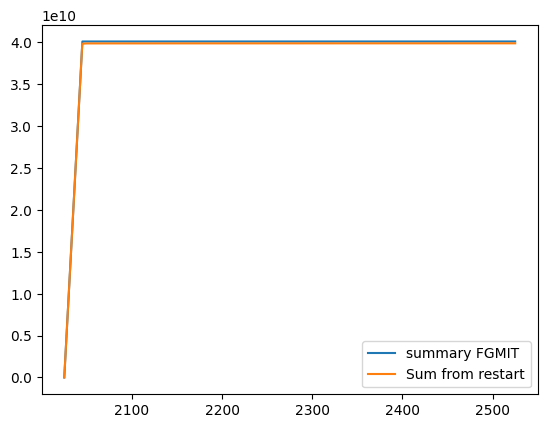

In [18]:
fig, ax = plt.subplots()

# summary.plot(x="ELAPSED", y ="FGMIT", ax=ax)

ax.plot(summary.index, summary['FGMIT'], label='summary FGMIT')

total_crs = df_rst_crs.groupby('tstep').sum()
total_lgr = df_rst_lgr.groupby('tstep').sum()
total = total_crs + total_lgr

time = np.array(tsteps)[:,1]
# ax.plot(np.array(tsteps)[:,1], total_crs['CO2_AQ'] + total_lgr['CO2_AQ'] + total_crs['CO2_G'] + total_lgr['CO2_G'])
# ax.plot(np.array(tsteps)[:,1],  total_crs['CO2_G'] + total_lgr['CO2_G'])
# ax.plot(np.array(tsteps)[:,1], total_crs['CO2_AQ'] + total_lgr['CO2_AQ'])

# ax.stackplot(np.array(tsteps)[:,1], total_crs['CO2_AQ'] ,total_lgr['CO2_AQ'], total_crs['CO2_G'] ,total_lgr['CO2_G'])
# ax.plot(np.array(tsteps)[:,1], total_crs['CO2_G'])
# ax.plot(time, total_sea['CO2_AQ'] + total_sea['CO2_G'])
# ax.plot(time, total_ovb['CO2_AQ'] + total_ovb['CO2_G'])
ax.plot(time, total['CO2_AQ'] + total['CO2_G'], label = 'Sum from restart' )

ax.legend()